# This notebook analyzes FVS benchmark results and produces various graphics

In [1]:
#
# Configure these settings to reflect your local setup
#

DEEP1B_DATASETS= {  \
    "deep1M": { \
        "plottitle": "1M of Deep1B", \
        "queries": { \
            10: "results/benchmarks-%s-q10.csv",\
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        } \
    }, \
    "deep2M": { \
        "plottitle": "2M of Deep1B", \
        "queries": { \
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        } \
    }, \
    "deep5M": {
        "plottitle": "5M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        }
    }, \
    "deep10M": {
        "plottitle": "10M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        }
    }, \
    "deep20M": {
        "plottitle": "20M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv", \
            1000: "results/benchmarks-%s-q1000.csv" \
        }
    }, \
    "deep50M": {
        "plottitle": "50M of Deep1B",
        "queries": {
            10: "results/benchmarks-%s-q10.csv", \
            100: "results/benchmarks-%s-q100.csv"
        }
    }              
}

NUM_APUS=4 #TODO: We should get from the allocation_id

MAIN_MEMORY_SIZE = "700G"

In [2]:
#
# Imports
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#
# Load all the CSV files into a master dataframe
#

all_dfs= []

for dset in DEEP1B_DATASETS.keys():
    for num_queries in DEEP1B_DATASETS[dset]["queries"].keys():
        df = pd.read_csv( DEEP1B_DATASETS[dset]["queries"][num_queries] % dset )
        
        df['dset_name'] = dset
        df['num_queries'] = num_queries
        all_dfs.append( df )


df_all = pd.concat( all_dfs )
print(df_all.shape)
print(df_all.columns)


(255, 14)
Index(['allocationid', 'datasetid', 'dataset_path', 'queries_path', 'bits',
       'ts_start', 'ts_train_start', 'ts_train_end', 'ts_query_start',
       'ts_query_end', 'response', 'recall', 'dset_name', 'num_queries'],
      dtype='object')


In [4]:
#
# Create throughput column
#

df_all['throughput'] = df_all.apply( \
            lambda row: row['num_queries']/row['response'], axis=1 )
    
print(df_all[["dset_name","bits","response","recall", "throughput"]])

   dset_name  bits  response  recall  throughput
0     deep1M   768  0.020478   1.000  488.334710
1     deep1M   768  0.017423   1.000  573.953474
2     deep1M   768  0.018164   1.000  550.533013
3     deep1M   512  0.021775   1.000  459.249379
4     deep1M   512  0.020864   1.000  479.303071
..       ...   ...       ...     ...         ...
10   deep50M   128  0.507390   0.941  197.087081
11   deep50M   128  0.510439   0.941  195.909866
12   deep50M    64  0.252739   0.773  395.664682
13   deep50M    64  0.254655   0.773  392.687923
14   deep50M    64  0.247269   0.773  404.418214

[255 rows x 5 columns]


In [5]:
# 
# Grouping rows by (num_queries,bits) and then average 'recall' and 'throughput'
# 

df_plot = \
    df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).mean()
print(df_plot)

   dset_name  num_queries  bits  recall  throughput
0    deep10M           10    64  0.9100  490.984538
1    deep10M           10   128  0.9900  455.636996
2    deep10M           10   256  0.9900  359.225078
3    deep10M           10   512  1.0000  220.929155
4    deep10M           10   768  1.0000  154.387235
..       ...          ...   ...     ...         ...
80    deep5M         1000    64  0.8820  919.881281
81    deep5M         1000   128  0.9738  720.561335
82    deep5M         1000   256  0.9980  702.300554
83    deep5M         1000   512  0.9998  206.558893
84    deep5M         1000   768  1.0000  845.129528

[85 rows x 5 columns]


In [6]:
# get min and max error bars for throughput

aggs = df_all[["dset_name", "num_queries","bits","recall","throughput"]].\
        groupby(["dset_name",'num_queries', 'bits'], as_index=False).\
                agg({'throughput': [('min_error', lambda x: x.mean() - x.min()), ('max_error', lambda x: x.max() - x.mean())]})

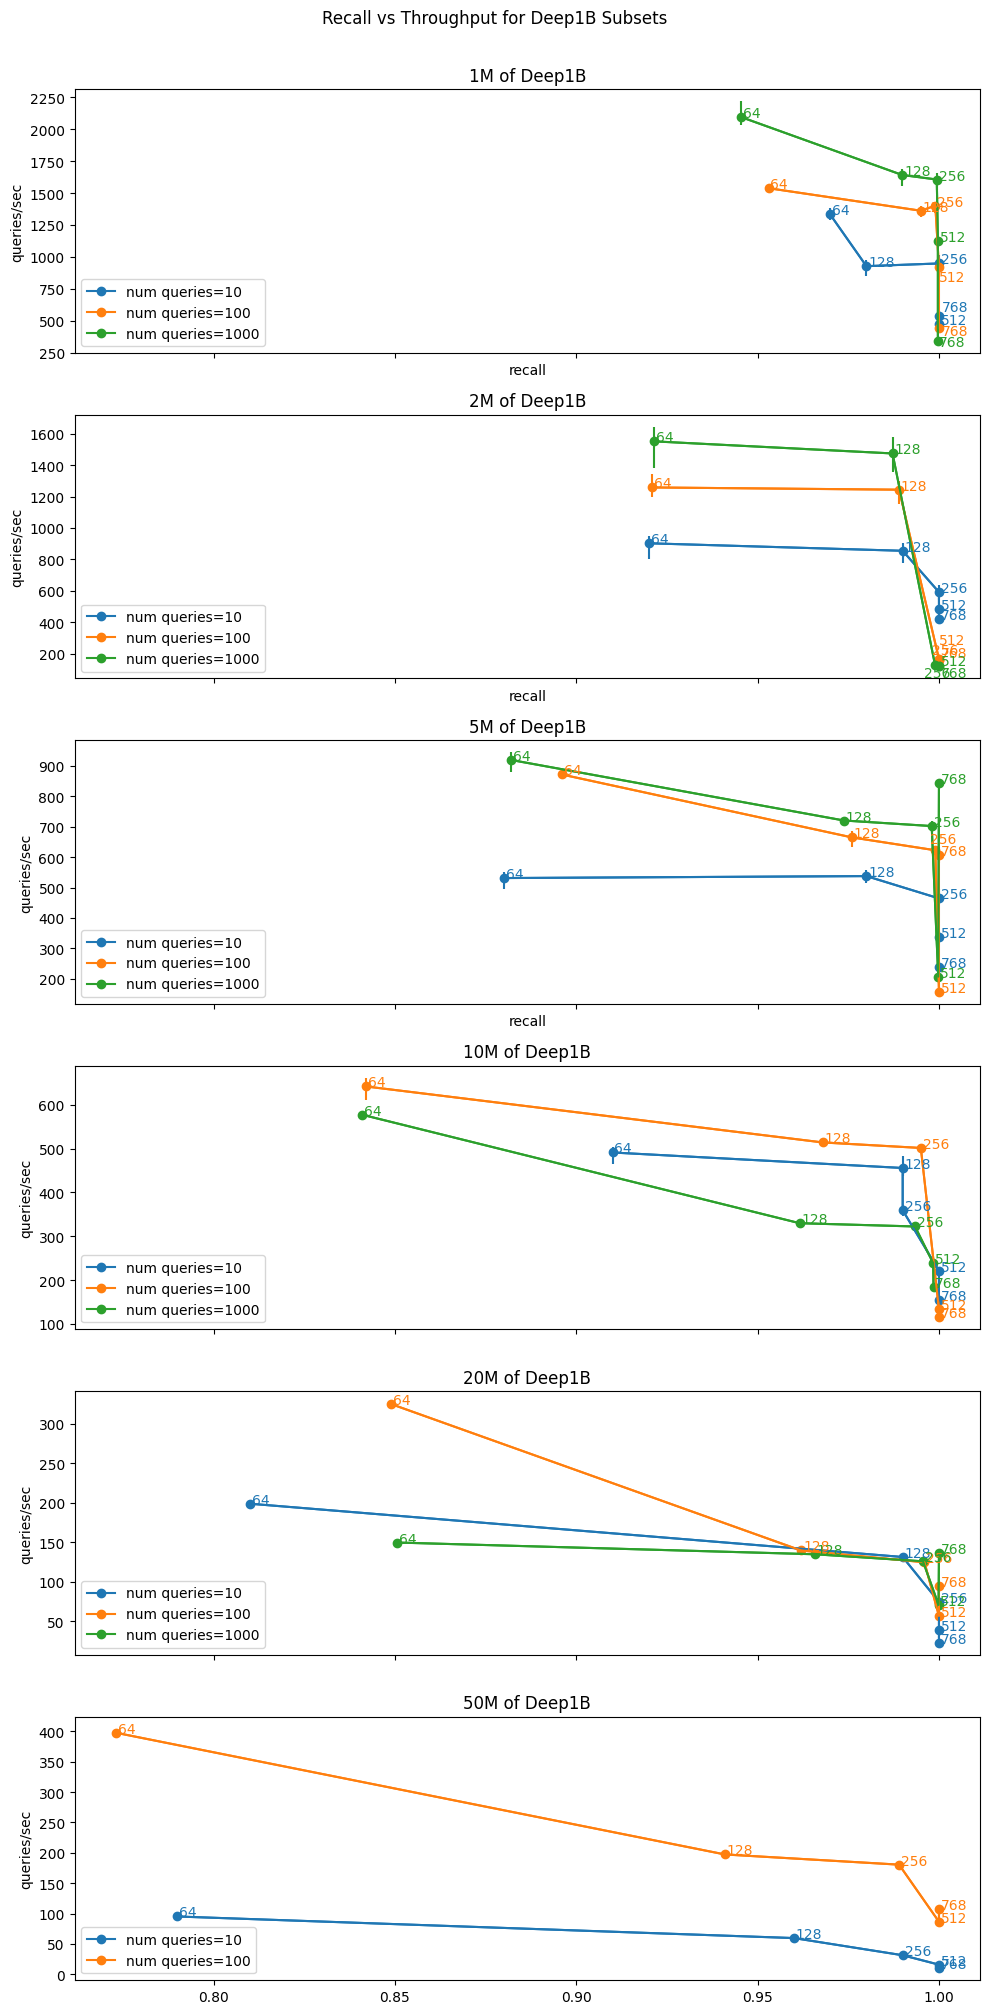

In [14]:
# 
# Plot the data
# 
num_plots = len( DEEP1B_DATASETS.keys() )

fig, axs = plt.subplots(num_plots, sharex=True, figsize=(10,20))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
for d, dset in enumerate(DEEP1B_DATASETS.keys()):
    for q, num_queries in enumerate(DEEP1B_DATASETS[dset]["queries"]):
        y_errormin = aggs.loc[ \
            (aggs['dset_name']==dset) & \
            (aggs['num_queries'] == num_queries)].\
                throughput['min_error']
        y_errormax = aggs.loc[ \
            (aggs['dset_name']==dset) & \
            (aggs['num_queries'] == num_queries)].\
                throughput['max_error']
        y_error = [y_errormin, y_errormax]
        recalls = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["recall"]
        throughputs = df_plot.loc[ \
                (df_plot['dset_name']==dset) & \
                (df_plot['num_queries']==num_queries)\
                ]["throughput"]
        bits = df_plot.loc[ \
            (df_plot['dset_name']==dset) & \
            (df_plot['num_queries']==num_queries)\
            ]["bits"]
        for i in bits.index: # text for bits, added .0005 for readability
            axs[d].text(recalls[i]+.0005, throughputs[i], bits[i], color=colors[q])
        axs[d].errorbar(recalls, throughputs, yerr=y_error)
        axs[d].plot( recalls, throughputs, '-o',label="num queries=%d" % num_queries, color=colors[q])
        axs[d].set_title( DEEP1B_DATASETS[dset]["plottitle"] )
        axs[d].set_ylabel("queries/sec")
        if d==len(DEEP1B_DATASETS[dset].keys())-1:
            axs[d].set_xlabel("recall")
        axs[d].legend(loc='lower left')

# TODO: fix with a function or package maybe
# 1M
axs[0].texts[4].set_position((1.0007, 575.0)) #blue 768
axs[0].texts[8].set_position((1.0, 813.0)) #orange 512
axs[0].texts[9].set_position((1.0007, 390.0)) #orange 768
axs[0].texts[14].set_position((1.0, 300.0)) #green 768
# 2M
axs[1].texts[7].set_position((0.998, 200.0)) #orage 256
axs[1].texts[8].set_position((0.99995, 259)) #orage 512
axs[1].texts[9].set_position((1.0006, 180.0)) #orange 765
axs[1].texts[12].set_position((0.996, 50.0)) #green 256
axs[1].texts[13].set_position((1.0006, 125.0)) #green 512
axs[1].texts[14].set_position((1.0005, 50.0)) #green 768
# 5M
axs[2].texts[7].set_position((0.9975, 645.0))

axs[0].set_xlabel("recall")
axs[1].set_xlabel("recall")
axs[2].set_xlabel("recall")
plt.suptitle("Recall vs Throughput for Deep1B Subsets",y=1.005)
plt.tight_layout()
plt.savefig("results/gemini_fvs_deep1B.png")